# Figure 2: CH read calling data
This script is used to reproduce figures on figure 2 in the MSc project report

## Set up

In [2]:

# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import plotly.express as px
import kaleido


In [3]:
# specify font for plotting 
plt.rcParams.update({'font.sans-serif':'Verdana'})

In [4]:
# get current date 
timestr = time.strftime("%Y%m%d") 

In [5]:
# stop printing warnings 
import warnings
warnings.filterwarnings("ignore")

## Load the dataset with CH cases and all screened datasets

In [6]:

# Import all the data (all calls: include singletons and higher read numbers, for all changes at a position affected in CH)

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  

# get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# initialize an empty dictionary 
dataframes = {}

# iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign df to a variable with the file name

# concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# combine all dfs into one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])

Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [7]:

# change numerical variables to integers
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# view the data
batch_all.head(n = 5)

,sample_ID,chromosome,position,end_position,ref,alt,depth,var_depth,VAF,variant_type,...,EXON,GIVEN_REF,IMPACT,INTRON,STRAND,SYMBOL,SYMBOL_SOURCE,USED_REF,VARIANT_CLASS,batch
0,2100020,chr17,7674230,7674230,C,A,32,1,0.031250,SNV,...,7/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
1,2100020,chr17,7675088,7675088,C,T,54,1,0.018519,SNV,...,5/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
2,2100033,chr2,25234307,25234307,G,T,85,1,0.011765,SNV,...,23/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
3,2100071,chr2,25240439,25240439,G,A,92,1,0.010870,SNV,...,19/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
4,2100071,chr2,25240439,25240439,G,T,92,1,0.010870,SNV,...,19/23,G,LOW,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data


In [8]:

# Import indexes tested in each batch 

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  

# get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# initialize an empty dictionary
indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():

    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[9].split('.')[0] # remove file extension
    globals()[variable_name] = df  # assign the df to a variable with the file name

print('The total number of individuals in the UKBB:', sum(len(values) for values in indexes.values()))

The total number of individuals in the UKBB: 454800


## Identify CH variants in call data 

In [9]:

# The data that I imported is annotated but has not been filtered to only include variants that are present in CH

# prepare the dataframe for annotation
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all['variant_coord'] = batch_all['chromosome'].astype(str) + "_" + batch_all['end_position'].astype(str) 
batch_all['variant_coord'] = batch_all['variant_coord'].astype('category')

# create column with coordinates, gene affected and specific variant 
batch_all['variant_coord_pos'] = batch_all['variant_coord'].astype(str) +  "_" + batch_all['SYMBOL'].astype(str) + "_" + batch_all['ref'].astype(str) + "_" + batch_all['alt'].astype(str)
batch_all['variant_coord_pos'] = batch_all['variant_coord_pos'].astype('category')

# view added columns
batch_all.head(n = 5)

# NOTE: in some cases, the amino acid column only contains a single aa value
# that does NOT indicate that there was a nonsense mutation (ie STOP codon introduced)
# STOP codons ARE indicated in the dataframe with "*"

,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt,ref,variant_coord,variant_coord_pos
0,2100020,chr17,7674230,0.031250,1,32,G/C,TP53,Ggc/Tgc,batch_21_annotated_data,C,G,chr17_7674230,chr17_7674230_TP53_G_C
1,2100020,chr17,7675088,0.018519,1,54,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R,chr17_7675088,chr17_7675088_TP53_R_H
2,2100033,chr2,25234307,0.011765,1,85,P/Q,DNMT3A,cCg/cAg,batch_21_annotated_data,Q,P,chr2_25234307,chr2_25234307_DNMT3A_P_Q
3,2100071,chr2,25240439,0.010870,1,92,R/W,DNMT3A,Cgg/Tgg,batch_21_annotated_data,W,R,chr2_25240439,chr2_25240439_DNMT3A_R_W
4,2100071,chr2,25240439,0.010870,1,92,R,DNMT3A,Cgg/Agg,batch_21_annotated_data,None,R,chr2_25240439,chr2_25240439_DNMT3A_R_None


In [10]:

# import coordinate data (df created manually based on COSMIC)
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required columns
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref'].astype(str) + "_" + coord_gene_var['alt'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [11]:

# Annotation

# subset required columns
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])

# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with variants:', batch_all.shape[0])
print('Number of patients with variants:', len(batch_all.sample_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of patients with annotated variants:', len(batch_gene_vars.sample_ID.unique()))

# NOTE
# I will carry out further analysis on batch_gene_vars dataframe (= contains samples with reads with CH-specific variants)
# I am working on a df that is not filtered with respect to read number (ie retaining singletons)

Number of variants identified with annotations: 38
Number of samples with variants: 76718
Number of patients with variants: 52356
Number of samples with annotated variants: 40752
Number of patients with annotated variants: 33377


In [12]:
# find what CH variants have not been identified in the UKBB despite being on the list to screen 
not_in_ukbb = [item for item in coord_gene_var.gene_var.unique().tolist() if item not in gene_vars_count.gene_var.unique().tolist()]
print('CH variants not identified in the UKBB:', not_in_ukbb)

CH variants not identified in the UKBB: ['KIT_D816F', 'NPM1_W288fs', 'TP53_R273C', 'TP53_R273H']


# Select healthy individuals 

In [13]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

# select columns available 
age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']] 
# rename columns
age_df.columns.values[0] = 'sample_ID'
age_df.columns.values[1] = 'age'
 
print('Number of patients for whom age data is available:', len(age_df.sample_ID.unique()))
# NOTE: this excludes individuals diagnosed with cancer 

Number of patients for whom age data is available: 459385


In [14]:

# now, we need to compare the age distribution in people who carry a variant vs people who do NOT carry a variant
# therefore, we need to first identify the IDs of everyone who was examined for the presence of variants 

# which batches have been screened for the presence of CH variants?
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

# names of all dataframes with IDs 
all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]

# initialize an empty list to store the IDs of people you screened for the presence of CH variants
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:
        
        selected_ids.append(globals()[df_name])

# concat together 
ids_examined = pd.concat(selected_ids, ignore_index=True)

N = ids_examined.shape[0]
print('Number of samples examined for variants:', N)

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [15]:

# add age data to the UKBB CH dataset 

# list of everyone we screened 
ids_examined_list = ids_examined.sample_ID.tolist()
ids_examined_list = [int(x) for x in ids_examined_list]

# list of everyone we screened who is healthy
batch_ids_age = age_df[age_df['sample_ID'].isin(ids_examined_list)] 
ids_examined_with_age = batch_ids_age.sample_ID.tolist()

batch_all_age = batch_all[batch_all['sample_ID'].isin(ids_examined_with_age)] # df for everyone we screened who is healthy and has a variant 
batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'sample_ID') # add age to everyone you screened who has a CH variant


In [16]:
# ALL NUMBERS
print('Number of patients examined:', len(ids_examined_list))
print('Out of these, number of healthy patients:', len(batch_ids_age.sample_ID.unique()))

# SAMPLES WITH ANY VARIANT
print('Number of samples with ANY variant:', batch_all.shape[0])
print('Number of individuals with ANY variant:', len(batch_all.sample_ID.unique()))

print('Number of healthy samples with ANY variant:', batch_all_age.shape[0]) # this is relevant 
print('Number of healthy individuals with ANY variant:', len(batch_all_age.sample_ID.unique())) # this is relevant 
   
# SAMPLES WITH CH HOTSPOT VARIANT
print('Number of samples with a CH variant:', batch_gene_vars.shape[0])
print('Number of individuals with a CH variant:', len(batch_gene_vars.sample_ID.unique()))

print('Number of healthy samples with a CH variant:', batch_gene_age.shape[0]) # this is relevant 
print('Number of healthy individuals with a CH variant:', len(batch_gene_age.sample_ID.unique())) # this is relevant 
     

Number of patients examined: 99597
Out of these, number of healthy patients: 90966
Number of samples with ANY variant: 76718
Number of individuals with ANY variant: 52356
Number of healthy samples with ANY variant: 69797
Number of healthy individuals with ANY variant: 47729
Number of samples with a CH variant: 40752
Number of individuals with a CH variant: 33377
Number of healthy samples with a CH variant: 37059
Number of healthy individuals with a CH variant: 30420


# Test 1: CH specific vs non-CH variant

In [17]:

# NOTE: batch all is only taken from people you screened (ie the 99,597 ones you actually managed to get data for)

# identify reads which do not belong to either od the CH reads 
merged = batch_all_age.merge(gene_vars, on = 'variant_coord_pos', how='outer', indicator=True)
batch_not_ch = merged[merged['_merge'] == 'left_only']

# change variant depth to integer value 
batch_not_ch.var_depth = batch_not_ch.var_depth.astype(int)

batch_not_ch_counts = pd.DataFrame(batch_not_ch.var_depth.value_counts())
batch_not_ch_counts['var_depth'] = batch_not_ch_counts.index
batch_not_ch_counts = batch_not_ch_counts.reset_index(drop=True)
batch_not_ch_sorted = batch_not_ch_counts.sort_values(by = 'var_depth', ascending=True)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with variants:', batch_all.shape[0])
print('Number of patients with variants:', len(batch_all.sample_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of samples with variants other than CH hotspots:', batch_not_ch.shape[0])

batch_not_ch_sorted.head()


Number of variants identified with annotations: 38
Number of samples with variants: 76718
Number of patients with variants: 52356
Number of samples with annotated variants: 40752
Number of samples with variants other than CH hotspots: 32738


,count,var_depth
0,32226,1
1,401,2
2,48,3
3,10,4
4,9,5


In [18]:

# create a figure to display the distirbution of 1, 2, 3, 4 or more 
not_ch_counts = pd.Series(batch_not_ch.var_depth).value_counts().reset_index()
not_ch_counts.columns = ['var_depth', 'count']
not_ch_counts = not_ch_counts.sort_values(by = 'var_depth')
not_ch_counts['nr_reads_per_sample'] = np.where(not_ch_counts.var_depth == 1, 1,
                             np.where(not_ch_counts.var_depth == 2, 2,
                             np.where(not_ch_counts.var_depth == 3, 3,
                             np.where(not_ch_counts.var_depth >= 4, '4 or more', np.nan))))
not_ch_sum_read_nr = not_ch_counts.groupby('nr_reads_per_sample')['count'].sum().reset_index()
not_ch_sum_read_nr.columns = ['nr_reads_per_sample', 'count_not_ch']

yes_ch_counts = pd.Series(batch_gene_vars.var_depth).value_counts().reset_index()
yes_ch_counts.columns = ['var_depth', 'count']
yes_ch_counts = yes_ch_counts.sort_values(by = 'var_depth')
yes_ch_counts['nr_reads_per_sample'] = np.where(yes_ch_counts.var_depth == 1, 1,
                             np.where(yes_ch_counts.var_depth == 2, 2,
                             np.where(yes_ch_counts.var_depth == 3, 3,
                             np.where(yes_ch_counts.var_depth >= 4, '4 or more', np.nan))))
yes_ch_sum_read_nr = yes_ch_counts.groupby('nr_reads_per_sample')['count'].sum().reset_index()
yes_ch_sum_read_nr.columns = ['nr_reads_per_sample', 'count_ch']

# get a dataframe for both 
sum_read_nr = pd.merge(not_ch_sum_read_nr, yes_ch_sum_read_nr, on = 'nr_reads_per_sample')
sum_read_nr_melt = pd.melt(sum_read_nr, id_vars = 'nr_reads_per_sample')
sum_read_nr_melt.variable = sum_read_nr_melt.variable.astype('category')
sum_read_nr_melt.variable = sum_read_nr_melt.variable.map({'count_not_ch': 'Other variant', 'count_ch': 'CH hotspot'})
sum_read_nr_melt

,nr_reads_per_sample,variable,value
0,1,Other variant,32226
1,2,Other variant,401
2,3,Other variant,48
3,4 or more,Other variant,63
4,1,CH hotspot,38503
5,2,CH hotspot,1129
6,3,CH hotspot,334
7,4 or more,CH hotspot,786


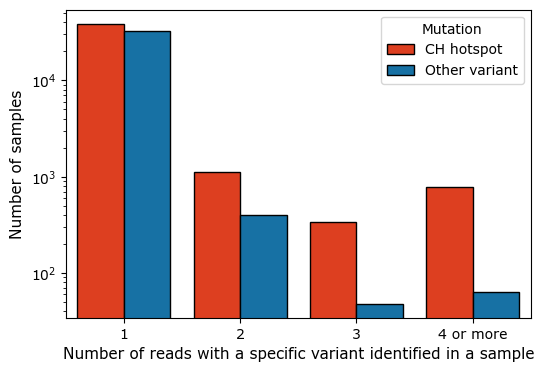

In [55]:

# plotting 
red0 = '#FC2A00'
blue0 = '#0077bb'
palette = [red0, blue0]

plt.figure(figsize = (6, 4))
sns.barplot(data = sum_read_nr_melt, x = 'nr_reads_per_sample', y = 'value', hue = 'variable', palette = palette, edgecolor = 'black')
plt.yscale('log')

plt.xlabel('Number of reads with a specific variant identified in a sample', fontsize = 11)
plt.ylabel('Number of samples', fontsize = 11)
plt.legend(fontsize = 11)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

legend = plt.legend()
legend.set_title('Mutation')

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 2/2c_barplot_compare_nr_reads_ch_hotspot_other_variant.pdf', bbox_inches='tight')


# Test 2: Age-dependence

In [20]:
# how to split people so we have roughly equal numbers in each bin?
age_bins = [40, 49, 57, 63, 70]
age_labels = ['40-48', '49-56', '57-62', '63-70']

# age distribution in everyone screened
batch_counts_a = batch_ids_age['age'].value_counts()
batch_counts_a = batch_counts_a.reset_index()
batch_counts_a.columns.values[0] = 'age'

# create a new column 'age_group' based on the specified intervals
batch_gene_age['age_group'] = pd.cut(batch_gene_age['age'], bins=age_bins, labels=age_labels, right=False)
age_order = ['40-48', '49-56', '57-62', '63-70']
batch_ids_age['age_group'] = pd.cut(batch_ids_age['age'], bins=age_bins, labels=age_labels, right=False)

# across all people examined, how many people are there in a given age range?
batch_counts_ag = batch_ids_age['age_group'].value_counts()
batch_counts_ag = batch_counts_ag.reset_index()
batch_counts_ag.columns.values[0] = 'age_group'
batch_counts_ag = batch_counts_ag.sort_values(by = 'age_group')
batch_counts_ag

,age_group,count
3,40-48,19855
2,49-56,22868
1,57-62,23733
0,63-70,24110


In [21]:

# Compare data for 1, 2, 3, 4 or more reads between CH- and non-CH variants

# Number of reads to look at 
nums = [1, 2, 3, 4]

# initialize an empty dictionary 
dfs_dict = {}

# loop over 1, 2, 3, 4 reads per sample   
for num in nums:

    if num < 4:
        df = batch_gene_age[batch_gene_age['var_depth'] == num] # select at the exact nr of reads per sample (1, 2, 3)
    
    if num == 4:
        df = batch_gene_age[batch_gene_age['var_depth'] >= num] # looking at 4 or more reads per sample
            
    # for each age group, how many people have a variant with a given nr of reads?
    df_ages = df['age_group'].value_counts() 
    df_ages = df_ages.reset_index()
    df_ages.sort_values(by = 'age_group')

    # merge 
    df_merge = pd.concat([batch_counts_ag, df_ages], axis = 1)
    df_merge = df_merge.iloc[:, [0, 1, 3]] # drop age_group duplicated column 
    df_merge[f'fraction_with_{num}_reads'] = df_merge.iloc[:, 2] / df_merge.iloc[:, 1] # calculate fraction positive 
    df_merge[f'percent_with_{num}_reads'] = df_merge[f'fraction_with_{num}_reads'] * 100 # fraction CH+ for each age group

    dfs_dict[num] = df_merge

df_merge.head()

,age_group,count,count,fraction_with_4_reads,percent_with_4_reads
3,40-48,19855,54,0.002720,0.271972
2,49-56,22868,120,0.005248,0.524751
1,57-62,23733,179,0.007542,0.754224
0,63-70,24110,326,0.013521,1.352136


In [22]:
# okay now plot this on a single plot to make it easier to understand 

df_1read = dfs_dict[1][['age_group', 'percent_with_1_reads']]
df_2read = dfs_dict[2][['age_group', 'percent_with_2_reads']]
df_3read = dfs_dict[3][['age_group', 'percent_with_3_reads']]
df_4read = dfs_dict[4][['age_group', 'percent_with_4_reads']]

# merge dfs 
df_reads_age_merged = pd.concat([df_1read, df_2read, df_3read, df_4read], axis = 1)
df_reads_age_merged = df_reads_age_merged.loc[:, ~df_reads_age_merged.columns.duplicated()] # drop duplicated columns
df_reads_age_merged = df_reads_age_merged.sort_values(by = 'age_group')

# prepare for plotting (melt)
df_reads_age_merged_melt = pd.melt(df_reads_age_merged, id_vars = 'age_group')
df_reads_age_merged_melt.variable = df_reads_age_merged_melt.variable.astype('category')
df_reads_age_merged_melt.variable = df_reads_age_merged_melt.variable.map({'percent_with_1_reads': '1', 
                                                                            'percent_with_2_reads': '2',
                                                                            'percent_with_3_reads': '3',
                                                                            'percent_with_4_reads': '4 or more',})
df_reads_age_merged_melt.head()
# variable refers to the number of reads per sample
# value : percentage of the population in the given age group diagnosed as CH+ given this threshold of reads 


,age_group,variable,value
0,40-48,1,37.204734
1,49-56,1,38.066294
2,57-62,1,38.890996
3,63-70,1,39.800912
4,40-48,2,0.654747


In [23]:

# add number of samples to the dataframe (included in the legend on the plot)
df_reads_age_merged_melt_count = pd.merge(df_reads_age_merged_melt, batch_counts_ag, on = 'age_group')
df_reads_age_merged_melt_count['legend_label'] = df_reads_age_merged_melt_count['age_group'].astype(str) + ' (n=' + df_reads_age_merged_melt_count['count'].astype(str) + ')'

In [24]:
# get error bars 

# 95% confidence interval so choose z = 1.96
z = 1.96

# add column with standard error 
df_reads_age_merged_melt_count['std_error'] = np.sqrt(df_reads_age_merged_melt_count['value'] * (100 - df_reads_age_merged_melt_count['value']) / df_reads_age_merged_melt_count['count'])

# add column with margin of error 
df_reads_age_merged_melt_count['margin_of_error'] = z * df_reads_age_merged_melt_count['std_error']

# Calculate confidence interval
df_reads_age_merged_melt_count['lower_bound'] = df_reads_age_merged_melt_count['value'] - df_reads_age_merged_melt_count['margin_of_error']
df_reads_age_merged_melt_count['upper_bound'] = df_reads_age_merged_melt_count['value'] + df_reads_age_merged_melt_count['margin_of_error']

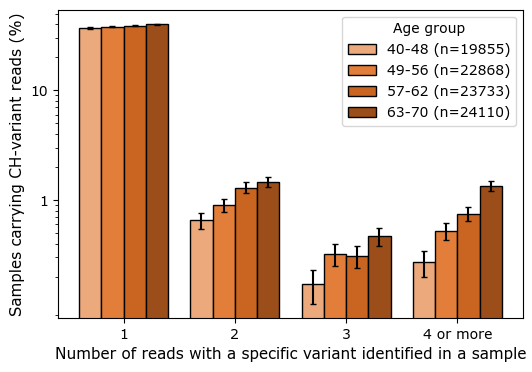

In [54]:

# plotting 

# specify colors 
orange0 = '#FFA569'
orange1 = '#FF781E'
orange2 = '#E55F05' 
orange3 = '#B24A04'
palette = [orange0, orange1, orange2, orange3]

# plotting 
plt.figure(figsize = (6, 4))
sns.barplot(data = df_reads_age_merged_melt_count, x = 'variable', y = 'value', hue = 'legend_label', palette = palette, edgecolor = 'black')
plt.yscale('log')

plt.xlabel('Number of reads with a specific variant identified in a sample', fontsize = 11)
plt.ylabel('Samples carrying CH-variant reads (%)', fontsize = 11)
plt.legend(fontsize = 11)
legend = plt.legend()
legend.set_title('Age group')

y_axis_ticks = [1, 10]
plt.yticks(y_axis_ticks, y_axis_ticks)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

# add error bars 
hues = df_reads_age_merged_melt_count['legend_label'].unique().tolist()
categories = df_reads_age_merged_melt_count['variable'].unique().tolist()

for i, category in enumerate(categories):

    subset_df = df_reads_age_merged_melt_count[df_reads_age_merged_melt_count['variable'] == category]
    
    for j, hue in enumerate(hues):
        
        # Filter data for the current category
        hue_df = subset_df[subset_df['legend_label'] == hue]
        
        # Extracting values
        percentage = hue_df['value'].iloc[0]
        lower_bound = hue_df['lower_bound'].iloc[0]
        upper_bound = hue_df['upper_bound'].iloc[0]
        
        # Calculate error bar values
        lower_error = percentage - lower_bound
        upper_error = upper_bound - percentage
        
        # Adding error bars
        # specify x positions
        if j == 0:
            pos = i - 0.3
        elif j == 1:
            pos = i - 0.1
        elif j == 2:
            pos = i + 0.1
        else:   
            pos = i + 0.3

        plt.errorbar(x=pos, y=percentage, yerr=[[lower_error], [upper_error]], fmt='none', capsize=2, color='black')

plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 2/2d_barplot_read_nr_age_dependence_combined.pdf', bbox_inches='tight')


# Evidence 3: Math model 

## Import the data

In [26]:

# set up a dictionary of CH cases from the UK BioBank 
# NB we ignore the fact that a lot of our reads are just a bit random and do not really correspond to the hotspots 
import csv

list_of_VAF = []
list_of_var_depths = []

# Read all batches in the folder 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'

# Iterate over each file in the folder
for filename in os.listdir(folder_path):

    if filename.endswith(".txt"):  # search for files in the folder with a tsv extension
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as csvfile:
            read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
            row_count=0
            
            vaf_id_dict = {}

            for row in read_reader:
        #         print((row.keys()))
                patient_id = row['sample_ID']
                VAF = row['VAF']
                total_depth = row['depth']
                var_depth = int(row['var_depth'])
                if var_depth >=4: # select only cases where there are at least 4 reads with the variant detected 
                    list_of_VAF.append(VAF)
                    list_of_var_depths.append(var_depth)
                    vaf_id_dict[patient_id] = VAF

print('number of high VAF variants in analysis:', len(list_of_VAF))

# sanity check (loaded the correct data)
print("Example VAFs:", list_of_VAF[0:4])
print("Example variant depths:", list_of_var_depths[0:4])


number of high VAF variants in analysis: 864
Example VAFs: ['0.048780487804878', '0.1311475409836065', '0.0975609756097561', '0.5384615384615384']
Example variant depths: [4, 8, 4, 14]


In [27]:

# set up dictionary of UKBB participants 
import csv

# Read all batches in the folder 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids_current'

list_of_ppl_interrogated = []

for filename in os.listdir(folder_path):

    if filename.endswith(".tsv"):  # search for files in the folder with a tsv extension
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as csvfile:
            read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
            row_count=0

            for row in read_reader:
        
                patient_ID = row['batch ID'][0:7]
                list_of_ppl_interrogated.append(patient_ID)
            
print('number of people examined:', len(list_of_ppl_interrogated))           

filename="/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/from_gladys/ages_for_gladys_barbara.tsv"

list_of_ages = []

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0
    
    for row in read_reader:
        
        patient_age = float(row['Age.when.attended.assessment.centre_v0'])
        patient_ID = row['ID_v0']

        if patient_ID in list_of_ppl_interrogated:
            
            list_of_ages.append(patient_age)
        
print('Number of cases with age data:', len(list_of_ages)) 
print('the mean age of people in analysed batches is:', int(sum(list_of_ages) / len(list_of_ages)))
print('the max age of people in analysed batches is:', max(list_of_ages))
print('the min age of people in analysed batches is:', min(list_of_ages))       

# It throws an error (could not convert string to float: '')
# This is because in the last row, you have a black space
# You don't need to worry about it 

# note this may take a while to run 


number of people examined: 99597


ValueError: could not convert string to float: ''

## Plot the data

In [28]:

# define necessary plotting functions
def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

def log_hist_data_for_plot(study_VAFs, study_total, study_mu, bin_size):
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
#     bin_size = int((max(log_VAFs)-min(log_VAFs))/(1/((len(log_VAFs))**(1/3))))
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    return bin_centres, log_hist_for_plot, errors

def plot_log_hist_data_for_plot_normalized(study_VAFs, study_total, n_bins, lmin, lmax, study_name, marker_name, marker_size, color):
    # study_VAFs is a list of strings
    
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = study_total
    hist, bins = np.histogram(log_VAFs, bins=n_bins, range=(lmin, lmax))
    print('bins:', bins)
    print('Hist is:', hist)
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
 

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
    print('hist without zero is', hist_without_zero)
    width_scalar=widths[0]
    normalised_hist = hist_without_zero/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist_without_zero, normed_value, widths)

    axisfont=14*1.2
    axislabelfont=15*1.2
    tpfont = 14*1.2

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(bin_centres_without_zero, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=3)
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    ax1.set_ylim(min(log_hist_for_plot), max(log_hist_for_plot))
    ax1.set_xlim(np.log(10**-3), 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('normalized density of variants', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks =  [np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
                  
    x_major_tick_labels =  [ "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = 'grey', length = 6)

    y_major_ticks = [np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_ticks = [c-np.log(10**6) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{-4}$","", "", "", "", "", "", "", "", "$10^{-3}$","", "", "", "", "", "", "", "", \
                           "$10^{-2}$","", "", "", "", "", "", "", "", "$10^{-1}$","", "", "", "", "", "", "", "", "$10^{0}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = 'grey', length = 6)
    

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color('grey')

    return ax1

In [29]:

binmethod = 'doane'

m_size = 14
Boltonmarkersize = m_size*1
Razavimarkersize = m_size*1
Coombsmarkersize = m_size*1.2
Youngmarkersize = m_size*1.2
Desaimarkersize = m_size*1.5
Jaiswalmarkersize = m_size*1.2
Genovesemarkersize = m_size*1.1

line_width = 6
a = 0.75

bins: [-3.21887582 -2.7137301  -2.20858437 -1.70343864 -1.19829291 -0.69314718]
Hist is: [182 184 190 160  91]
hist without zero is [182, 184, 190, 160, 91]
log_hist_for_plot is [-5.62197232 -5.61104325 -5.57895493 -5.75080519 -6.3151195 ]
errors is [(0.07701596884402662, 0.07657977015279194, 0.07531383353964216, 0.08235707037558981, 0.11073994071247295), (0.07150631303305666, 0.07113016538522743, 0.07003677643879858, 0.07608745736199385, 0.09969010452588734)]


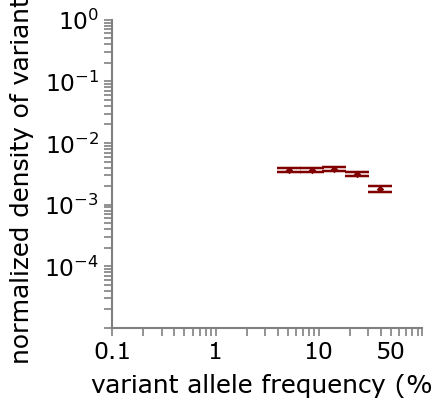

In [30]:

# plotting the histogram
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(4,4))

# fraction_of_drivers_that_matters = 0.6122039636083625

all468color = 'maroon'

n_bins_Bolton = 7
Boltonmarker = 'D'
lmin_Bolton = np.log(0.02)
lmax_Bolton = np.log(0.4999)
Boltonmarkersize = 2

plot_log_hist_data_for_plot_normalized(list_of_VAF, len(list_of_ages),\
                                         5, np.log(4/100), np.log(0.5),\
                            '  ', Boltonmarker, Boltonmarkersize, 'maroon')


x=np.linspace(np.log(10**-4), np.log(0.49999999999), 50)
ax1.set_ylim(np.log(10**-5), np.log(10**0))

# plt.savefig('Driver_analysis_top_291_gene_p_is_3_best_fit_DFE_with_dev_contrib_and_HH_contrib.pdf', bbox_inches='tight')
plt.show()

## Define theory functions

In [31]:

# Define the theory functions
# This is the expected probability density for a single fitness and a single age 

# this is the probability density  of clone sizes that depends on age, mu, N_tau, s (f = clone size)
def rho(age, mu, N_tau, s, l):

    """
    rho of f is the expected density of the variant being present at a given frequency (2f = n / (n + N) where n is the clone size and N the total number of cells)
    N_tau is the total number of cells (= population size) * division rate 
    mu is the mutation rate 
    age is the age of the participant (> sets the maximum size of the clone assuming a given growth rate)
    s is the fitness effect of the mutation (growth rate)
    """

    theta = 2 * N_tau * mu
    fi = (np.exp(s*age) - 1) / (2 * N_tau * s)

    num = theta / (1-2*np.exp(l))
    exponent = np.exp(- ((np.exp(l))/fi) / (1 - 2*np.exp(l)) ) 
    
    rho = num * exponent

    if rho <= 0:
        return 0
    else:
        return rho


In [32]:

# format x axis ticks 
import matplotlib.ticker as ticker

def log_to_nonlog(x, pos):
    return "{:.1g}".format(np.exp(x))
  

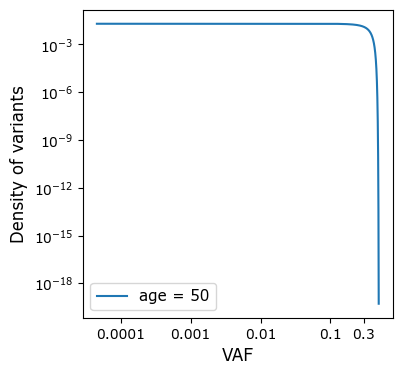

In [34]:

# example plot to see the shape of the function
mu = 10**-7
s = 0.2
N_tau = 10**5

list_values = np.arange(-10, np.log(0.49), 0.0001).tolist()
result = [rho(50, mu, N_tau, s, l) for l in list_values]

plt.figure(figsize = (4,4))
plt.plot(list_values, result, label = 'age = 50')
plt.yscale('log')

plt.xlabel('VAF', fontsize = 12)
plt.ylabel('Density of variants', fontsize = 12)

plt.xticks(fontsize=10)  
plt.yticks(fontsize=10)

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend(fontsize = 11)

plt.show()

## Age distribution in the population

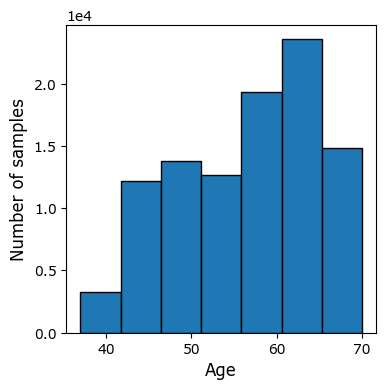

Age bins examined: [(40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74)]
The fraction of people in the UKBB in a given age group: [0.10407944014377943, 0.13147986385132082, 0.15192224665401569, 0.17842906914866913, 0.24155346044559575, 0.1876763356325994, 0.0048093818086890165]
The total fraction of the population covered: 0.9999497976846693


In [35]:

# I am going to be doing a weighed sum across age bins, so I need to know how many people I have in each age group

plt.figure(figsize = (4,4))
plt.hist(list_of_ages, bins = 7, edgecolor = 'black')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # scientific notation
plt.show()

# I need the distribution of age groups
def count_values_in_intervals(value_list, interval_list):
    counts = [0] * len(interval_list)

    for value in value_list:
        for i, (lower, upper) in enumerate(interval_list):
            if lower <= value <= upper:
                counts[i] += 1
                break

    return counts

intervals = [(40, 44), (45, 49), (50, 54), (55, 59), (60, 64), (65, 69), (70, 74)]
counts_ages = count_values_in_intervals(list_of_ages, intervals)
fraction_ages = [c / len(list_of_ages) for c in counts_ages] # you will want to take a weighed sum of this 

print('Age bins examined:', intervals)
print('The fraction of people in the UKBB in a given age group:', fraction_ages)
print('The total fraction of the population covered:', sum(fraction_ages)) #sums up to ~0.999 so this suggests this is a correct thing 

In [36]:

# age bins
mean_age = [42, 47, 52, 57, 62, 67, 72]
ages_df = pd.concat([pd.DataFrame(fraction_ages), pd.DataFrame(mean_age)], axis = 1)
ages_df.columns = ['fraction', 'mean_age']
ages_df

,fraction,mean_age
0,0.104079,42
1,0.131480,47
2,0.151922,52
3,0.178429,57
4,0.241553,62
5,0.187676,67
6,0.004809,72


## Weighted sum

In [37]:

# here are some parameters
mu = 10**-7
s = 0.12
N_tau = 10**5

list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist()

# initialize the array to write to 
weighted_sum = np.zeros_like(list_values)

# these are the ages and the corresponding fraction of the population in a given age bin
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

# calculate the weighed sum (weighed by fraction of people in a given age group)
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]


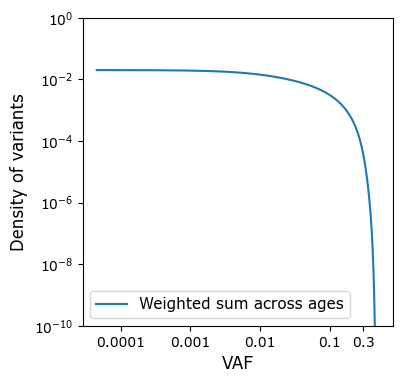

In [38]:

# plot the figure 
plt.figure(figsize = (4,4))

plt.plot(list_values, weighted_sum, label='Weighted sum across ages')
plt.yscale('log')
plt.ylim(10**-10, 10**0)

plt.xlabel('VAF', fontsize = 12)
plt.ylabel('Density of variants', fontsize = 12)
plt.legend(fontsize = 11, loc = 'lower left')

plt.xticks([np.log(0.0001), np.log(0.001), np.log(0.01), np.log(0.1), np.log(0.3)])
formatter = ticker.FuncFormatter(log_to_nonlog)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

## Move from continuous to discrete prediction

In [39]:

# define functions for binomial subsampling and total probability
from math import comb

# probability that you see a certain number of reads given coverage (from binomial)
def prob_of_n_reads_from_binomial_subsampling(l, total_depth, var_depth):
    return comb(total_depth, var_depth)*(np.exp(l)**var_depth)*(1-np.exp(l))**(total_depth-var_depth) # l has been logged so we need to exponentiate to get back to percentage 

# total probability (binomial * predicted density of the clone size)
def prob_of_n_reads_across_all_VAFs(l_vector, fitted_VAF, total_depth, var_depth):
    l_diff = l_vector[1]-l_vector[0]
    
    total_prob = 0
    for l, log_rho in zip(l_vector, fitted_VAF):
        prob_of_variant_at_l = np.exp(log_rho)*l_diff 
        # rho is the estimated probability and it also has been logged
        # probability of variant at l calculated the area under the rho curve for a given l interval 

        total_depth = int(total_depth) # we need to do this because you are doing (N choose n) so you need integers
        subsampling_prob = prob_of_n_reads_from_binomial_subsampling(l, total_depth, var_depth) # B(p, n) ~ B(l, total depth); l = VAF
        contrib = prob_of_variant_at_l*subsampling_prob
        total_prob += contrib # this is equivalent to saying total_prob = total_prob + contrib 
        
    return total_prob

## Create expectation based on theory 

In [40]:

# Create an expectation based on the theory 

# parameters 
mu = 10**-7
s = 0.12
N_tau = 10**5

# VAF values 
list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist() # you are NOT using your VAF values, just any  

# calculate the weighed sum given the age distribution 
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

weighted_sum = np.zeros_like(list_values)
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]
fitted = np.log(weighted_sum)

# obtain the expected number of people with a given number of reads 
expected_counts = {}
for i in list(range(4,11)):
    expected_counts[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we will match this to the observed number (for 4-9) with further parameter fitting
expected_counts_df = pd.DataFrame(expected_counts, index = ['read count']).T
expected_counts_df = expected_counts_df.reset_index()
expected_counts_df.columns.values[0] = 'read number'
expected_counts_df = expected_counts_df.sort_values(by = 'read number')
expected_counts_df


,read number,read count
0,4,162
1,5,105
2,6,71
3,7,50
4,8,36
5,9,26
6,10,19


## Observed data (only CH variants)

In [41]:

# I want to use the number of reads that correspond to actual CH variants, not errors

# import the data 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    # Use pandas.read_csv to read the CSV file into a df
    df = pd.read_csv(csv_file, sep = '\t')

    # Store the df in the dictionary with the file name as the key
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # Construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    df['batch'] = variable_name # add column to indicate source 

    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


# contact all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

# create new useful columns (annotation)
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# subset the data such that only variants with >= 4 reads are considered
batch_all_ns = batch_all[batch_all['var_depth'] >= 4]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str)
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

num_variants = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord')
coord_out = num_variants['variant_coord'].tolist() # all coordinates in the batches  

# import coordinate data 
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required column
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str)
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0]
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0]
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1]
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str)

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str)
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0]
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0]
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1]
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str)

# merge
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']] # subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')

list_of_VAF_vars = batch_gene_vars.VAF.tolist()
list_of_var_depth_vars = batch_gene_vars.var_depth.tolist()

print('Number of samples examined:', len(list_of_VAF_vars))

Number of samples examined: 786


In [42]:

# OBSERVED: only CH variants included

observed_counts = {}

for element in list_of_var_depth_vars:
    if element in observed_counts:
        observed_counts[element] += 1
    else:
        observed_counts[element] = 1

observed_counts_df = pd.DataFrame(observed_counts, index = ['read count']).T
observed_counts_df = observed_counts_df.reset_index()
observed_counts_df.columns.values[0] = 'read number'
observed_counts_df = observed_counts_df.sort_values(by = 'read number')

# let's say we are only interested in 4 - 9
observed_counts_df = observed_counts_df[observed_counts_df['read number'] < 10]
observed_counts_df

,read number,read count
0,4.0,182
1,5.0,124
2,6.0,93
9,7.0,52
16,8.0,41
15,9.0,33


## Parameter optimization with grid search 

In [43]:

# compare observed to expected 
observed_counts_df.rename(columns={'read count': 'observed read count'}, inplace=True) # rename column in observed data 
expected_counts_df.rename(columns={'read count': 'expected read count'}, inplace=True) # rename column in observed data 
exp_obs = pd.merge(observed_counts_df, expected_counts_df, on = 'read number') # merge 
exp_obs

,read number,observed read count,expected read count
0,4.0,182,162
1,5.0,124,105
2,6.0,93,71
3,7.0,52,50
4,8.0,41,36
5,9.0,33,26


In [44]:

# optimize

# define functions needed to do grid search 
import numpy as np
from sklearn.metrics import mean_squared_error

# define a function to get the expected data points depending on s and mu
def get_expectation(mu, s):
    
    # N_tau is a parameter but we fix the value at 10**5 
    N_tau = 10**5

    # VAF values 
    list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist() # you are NOT using your VAF values, just any plausible values  

    # calculate the weighed sum given the age distribution 
    ages = [42, 47, 52, 57, 62, 67, 72]
    weights = fraction_ages 

    weighted_sum = np.zeros_like(list_values)
    for age, weight in zip(ages, weights):
        exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] # generate the prediction 
        weighted_sum += [weight * c for c in exp_distribution]
    fitted = np.log(weighted_sum)

    # obtain the expected number of people with a given number of reads 
    expected_counts = {}
    expected_counts_list = []
    for i in list(range(4,10)):
        exp_nr_cases = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))
        expected_counts[i] = exp_nr_cases
        expected_counts_list.append(exp_nr_cases)

    return expected_counts_list 

# define how good the fit is 
def fitness_score(observed, expected):
    return mean_squared_error(observed, expected)

# define the function to do grid search 
def grid_search(mu_values, s_values, observed_values):
    best_score = float('inf')  # Initialize best score with infinity
    best_params = None         # Initialize best parameters
    
    for mu in mu_values:
        for s in s_values:
            # Generate expected data points using the current parameter combination
            expected_values = get_expectation(mu, s)
            
            # Calculate fitness score
            score = fitness_score(observed_values, expected_values)
            
            # Check if the current score is better than the previous best score
            if score < best_score:
                best_score = score
                best_params = (mu, s)
            
    return best_params


In [45]:

# run grid search 

# list of observed datapoints 
observed_values = observed_counts_df['observed read count'].tolist()

# Grid search
best_score = float('inf')  # Initialize best score with infinity
best_params = None         # Initialize best parameters

# Initialize parameter values
mu_values = [10**-7, 5*10**-7, 10**-8, 5*10**-8, 10**-9]
s_values = [0.10, 0.125, 0.15, 0.175, 0.20]

best_params_dict = {}

# iterate 
for i in range(5):  # repeat 5 times 
    best_params = grid_search(mu_values, s_values, observed_values)
    best_params_dict[i] = best_params
    
    # search values around best parameters 
    mu_values = np.linspace(max(best_params[0] * 0.5, 0), best_params[0] * 2, 5)  # values around
    s_values = np.linspace(max(best_params[1] - 0.05, 0), best_params[1] + 0.05, 5)  # values around 
     
    print("Iteration", i+1, "Best parameters:", best_params)


Iteration 1 Best parameters: (1e-07, 0.125)
Iteration 2 Best parameters: (8.75e-08, 0.125)
Iteration 3 Best parameters: (1.0937499999999999e-07, 0.125)
Iteration 4 Best parameters: (9.570312499999998e-08, 0.125)
Iteration 5 Best parameters: (8.374023437499998e-08, 0.125)


In [46]:

# optimize further using established best parameters 

# so far, the best parameters are: 9.570312499999998e-08, 0.125
current_mu = 9.570312499999998e-08
current_s = 0.125

range_size_mu = 1*10**-8
range_size_s = 0.05

mu_range = np.linspace(current_mu - range_size_mu, current_mu + range_size_mu, num=20)
s_range = np.linspace(current_s - range_size_s, current_s + range_size_s, num=20)

# Perform grid search
best_fit = float('inf')
best_params = None # no best parameters at first 

fits = []

for mu in mu_range:
    for s in s_range:
        
        # get the result of the function 
        expected_values = get_expectation(mu, s)

        # check the fit 
        fit_metric = fitness_score(observed_values, expected_values)
        fits.append(fit_metric)
        
        # update best fit and best parameters 
        if fit_metric < best_fit:
            best_fit = fit_metric
            best_params = (mu, s)

print("Best parameters:", best_params)
print("Best fit:", best_fit)

Best parameters: (1.0359786184210525e-07, 0.12236842105263157)
Best fit: 27.5


### Make predictions

In [47]:

# EXPECTED

# parameters 
mu = 1.0359786184210525e-07 # parameters which we found work well
s = 0.122368
N_tau = 10**5

# VAF values 
list_values = np.arange(-10, np.log(0.49999), 0.0001).tolist() # you are NOT using your VAF values, just any  

# calculate the weighed sum given the age distribution 
ages = [42, 47, 52, 57, 62, 67, 72] # age values 
weights = fraction_ages # you calculated the fraction of people in this age bin here 

weighted_sum = np.zeros_like(list_values)
for age, weight in zip(ages, weights):
    exp_distribution = [rho(age, mu, N_tau, s, l) for l in list_values] 
    weighted_sum += [weight * c for c in exp_distribution]
fitted = np.log(weighted_sum)

# obtain the expected number of people with a given number of reads 
expected_counts = {}
for i in list(range(4,11)):
    expected_counts[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we would like this to match the observed number 
expected_counts
expected_counts_df = pd.DataFrame(expected_counts, index = ['read count']).T
expected_counts_df = expected_counts_df.reset_index()
expected_counts_df.columns.values[0] = 'read number'
expected_counts_df = expected_counts_df.sort_values(by = 'read number')
expected_counts_df = expected_counts_df.rename(columns={'read count': 'expected read count'})


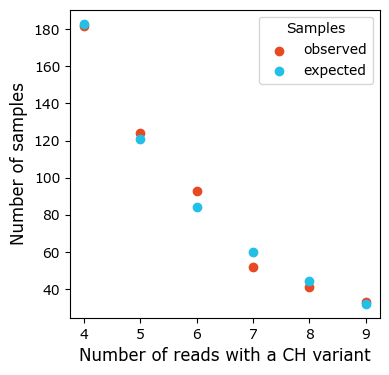

In [48]:

# merge the dataframe to compare observation and expectation
exp_obs = pd.merge(observed_counts_df, expected_counts_df, on = 'read number')
exp_obs['difference'] = exp_obs['observed read count'] - exp_obs['expected read count']
exp_obs['difference**2'] = exp_obs['difference']**2

# plot 
red1 = '#e74a22'
blue1 = '#22BFE7'
plt.figure(figsize = (4,4))
plt.scatter(exp_obs['read number'], exp_obs['observed read count'], label = 'observed', color = red1)
plt.scatter(exp_obs['read number'], exp_obs['expected read count'], label = 'expected', color = blue1)
plt.legend(fontsize = 11)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples',  fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks([4,5,6,7,8,9])
legend = plt.legend()
legend.set_title('Samples')
plt.show()

### Extend to 1-3 reads 

In [49]:

# okay do this again for all 1-11
# obtain the expected number of people with a given number of reads 
expected_counts1 = {}
for i in list(range(1,11)):
    expected_counts1[i] = int(prob_of_n_reads_across_all_VAFs(list_values, fitted , 70, i) * len(list_of_ppl_interrogated))

# now, this is our expectation for some set of parameters 
# we would like this to match the observed number 
expected_counts1
expected_counts1_df = pd.DataFrame(expected_counts1, index = ['read count']).T
expected_counts1_df = expected_counts1_df.reset_index()
expected_counts1_df.columns.values[0] = 'read number'
expected_counts1_df = expected_counts1_df.sort_values(by = 'read number')
expected_counts1_df = expected_counts1_df.rename(columns={'read count': 'expected read count'})


In [50]:

# Read all batches in the folder 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'
list_of_var_depths1 = []
list_of_VAF1 = [] 

# we want to read this file again but now append all cases with reads (ie include singletons, 2x etc)
for filename in os.listdir(folder_path):

    if filename.endswith(".txt"):  # search for files in the folder with a tsv extension
        file_path = os.path.join(folder_path, filename)

        with open(file_path, 'r') as csvfile:
            read_reader = csv.DictReader(csvfile, delimiter="\t")  #csv.reader returns a reader object which will iterate over lines in the csvfile
            row_count=0
            
            vaf_id_dict = {}

            for row in read_reader:
        #         print((row.keys()))
                patient_id = row['sample_ID']
                VAF = row['VAF']
                total_depth = row['depth']
                var_depth = int(row['var_depth'])
                if var_depth >=1: # select only cases where there are at least 4 reads with the variant detected 
                    list_of_VAF1.append(VAF)
                    list_of_var_depths1.append(var_depth)

print('number of high VAF variants in analysis:', len(list_of_VAF1))

observed_counts1 = {}

for element in list_of_var_depths1:
    if element in observed_counts1:
        observed_counts1[element] += 1
    else:
        observed_counts1[element] = 1


observed_counts_df1 = pd.DataFrame(observed_counts1, index = ['read count']).T
observed_counts_df1 = observed_counts_df1.reset_index()
observed_counts_df1.columns.values[0] = 'read number'
observed_counts_df1 = observed_counts_df1.sort_values(by = 'read number')

observed_counts_df1_sub = observed_counts_df1[observed_counts_df1['read number'] < 10]
observed_counts_df1_sub


number of high VAF variants in analysis: 76718


,read number,read count
0,1,73895
1,2,1570
6,3,389
2,4,195
5,5,133
8,6,102
10,7,60
3,8,48
11,9,37


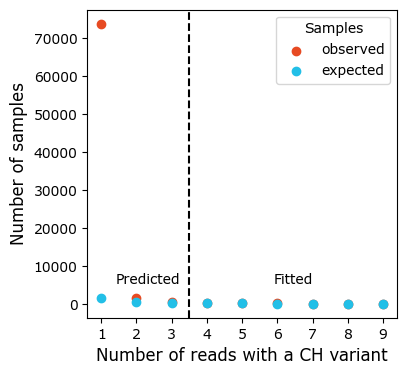

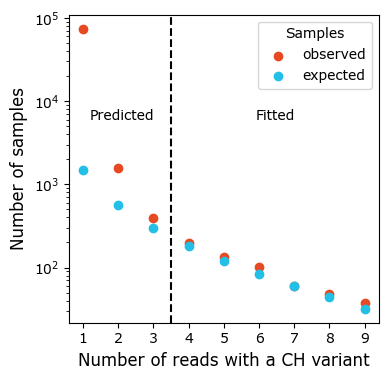

In [56]:

# merge the dataframe to compare observation and expectation
exp_obs1 = pd.merge(observed_counts_df1_sub, expected_counts1_df, on = 'read number')
exp_obs1['difference'] = exp_obs1['read count'] - exp_obs1['expected read count']
exp_obs1['difference**2'] = exp_obs1['difference']**2

red1 = '#e74a22'
blue1 = '#22BFE7'

# plot 
plt.figure(figsize = (4,4))
plt.scatter(exp_obs1['read number'], exp_obs1['read count'], label = 'observed', color = red1)
plt.scatter(exp_obs1['read number'], exp_obs1['expected read count'], label = 'expected', color = blue1)
plt.legend(fontsize = 11)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks([1,2,3,4,5,6,7,8,9])
legend = plt.legend()
legend.set_title('Samples')
plt.axvline(x=3.5, color='black', linestyle='--')
plt.text(1.4, 5400, 'Predicted', color='black', fontsize = 10)
plt.text(5.9, 5400, 'Fitted', color='black', fontsize = 10)
plt.show()

# plot 
plt.figure(figsize = (4,4))
plt.scatter(exp_obs1['read number'], exp_obs1['read count'], label = 'observed', color = red1)
plt.scatter(exp_obs1['read number'], exp_obs1['expected read count'], label = 'expected', color = blue1)
plt.legend(fontsize = 12)
plt.xlabel('Number of reads with a CH variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.yscale('log')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xticks([1,2,3,4,5,6,7,8,9])
legend = plt.legend()
legend.set_title('Samples')
# add line to separate fitted and predicted
plt.axvline(x=3.5, color='black', linestyle='--')
plt.text(1.2, 6000, 'Predicted', color='black', fontsize = 10)
plt.text(5.9, 6000, 'Fitted', color='black', fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 2/2b_scatterplot_expected_vs_observed_log_scale.pdf', bbox_inches='tight')


# Overview of obtained data

## Import data

In [57]:

# Import all the data (all calls: include singletons and higher read numbers, for all changes at a position affected in CH)

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  

# get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# initialize an empty dictionary 
dataframes = {}

# iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign df to a variable with the file name


# concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# combine all dfs into one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants:', batch_all.shape[0])

Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants: 76718


In [58]:

# change numerical variables to integers
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# view the data
batch_all.head(n = 5)

,sample_ID,chromosome,position,end_position,ref,alt,depth,var_depth,VAF,variant_type,...,first.diagnosed.cancer.date2,first.diagnosed.cancer.date3,first.diagnosed.cancer.histology1,first.diagnosed.cancer.histology2,first.diagnosed.cancer.histology3,first.diagnosed.cancer.behaviour1,first.diagnosed.cancer.behaviour2,first.diagnosed.cancer.behaviour3,exome200k,exome50k
0,2100020,chr17,7674230,7674230,C,A,32.0,1.0,0.031250,SNV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2100020,chr17,7675088,7675088,C,T,54.0,1.0,0.018519,SNV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2100033,chr2,25234307,25234307,G,T,85.0,1.0,0.011765,SNV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2100071,chr2,25240439,25240439,G,A,92.0,1.0,0.010870,SNV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2100071,chr2,25240439,25240439,G,T,92.0,1.0,0.010870,SNV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:

# Import indexes tested in each batch 

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  

# get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# initialize an empty dictionary
indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():

    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[9].split('.')[0] # remove file extension
    globals()[variable_name] = df  # assign the df to a variable with the file name


## Annotate with CH variants

In [60]:

# The data that I imported is annotated but has not been filtered to only include variants that are present in CH

# prepare the dataframe for annotation
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all['variant_coord'] = batch_all['chromosome'].astype(str) + "_" + batch_all['end_position'].astype(str) 
batch_all['variant_coord'] = batch_all['variant_coord'].astype('category')

# create column with coordinates, gene affected and specific variant 
batch_all['variant_coord_pos'] = batch_all['variant_coord'].astype(str) +  "_" + batch_all['SYMBOL'].astype(str) + "_" + batch_all['ref'].astype(str) + "_" + batch_all['alt'].astype(str)
batch_all['variant_coord_pos'] = batch_all['variant_coord_pos'].astype('category')

# view added columns
batch_all.head(n = 5)

# NOTE: in some cases, the amino acid column only contains a single aa value
# that does NOT indicate that there was a nonsense mutation (ie STOP codon introduced)
# STOP codons ARE indicated in the dataframe with "*"

,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt,ref,variant_coord,variant_coord_pos
0,2100020,chr17,7674230,0.031250,1.0,32.0,G/C,TP53,Ggc/Tgc,batch_21_annotated_data,C,G,chr17_7674230,chr17_7674230_TP53_G_C
1,2100020,chr17,7675088,0.018519,1.0,54.0,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R,chr17_7675088,chr17_7675088_TP53_R_H
2,2100033,chr2,25234307,0.011765,1.0,85.0,P/Q,DNMT3A,cCg/cAg,batch_21_annotated_data,Q,P,chr2_25234307,chr2_25234307_DNMT3A_P_Q
3,2100071,chr2,25240439,0.010870,1.0,92.0,R/W,DNMT3A,Cgg/Tgg,batch_21_annotated_data,W,R,chr2_25240439,chr2_25240439_DNMT3A_R_W
4,2100071,chr2,25240439,0.010870,1.0,92.0,R,DNMT3A,Cgg/Agg,batch_21_annotated_data,None,R,chr2_25240439,chr2_25240439_DNMT3A_R_None


In [61]:

# import coordinate data (df created manually based on COSMIC)
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required columns
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref'].astype(str) + "_" + coord_gene_var['alt'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [62]:
batch_all_age = batch_all[batch_all.sample_ID.isin(ids_examined_with_age)]

In [63]:
# Annotation

# subset required columns
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_age, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples examined:', batch_all.shape[0])
print('Number of patients examined:', len(batch_all.sample_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of patients with annotated variants:', len(batch_gene_vars.sample_ID.unique()))

Number of variants identified with annotations: 38
Number of samples examined: 76718
Number of patients examined: 52356
Number of samples with annotated variants: 37059
Number of patients with annotated variants: 30420


In [64]:

# Filtering: based on the results of the above, we decided that inclusion of samples with 2 reads is justified 

batch_all_ns = batch_all[batch_all['var_depth'] >= 2] # we require at least two reads here
batch_gene_vars_ns = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars_ns['gene_var'] = batch_gene_vars_ns['gene_var'].astype('category')

batch_all_3 = batch_all[batch_all['var_depth'] >= 3] # just to check how many samples we would have in this case
batch_gene_vars_3 = pd.merge(batch_all_3, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars_3['gene_var'] = batch_gene_vars_3['gene_var'].astype('category')

batch_gene_vars_ns_age = batch_gene_vars_ns[batch_gene_vars_ns['sample_ID'].isin(ids_examined_with_age)]
batch_gene_vars_3_age = batch_gene_vars_3[batch_gene_vars_3['sample_ID'].isin(ids_examined_with_age)]

print('Number of samples with annotated variants (>= 2 reads):', batch_gene_vars_ns.shape[0])
print('Number of patients with annotated variants (>= 2 reads):', len(batch_gene_vars_ns.sample_ID.unique()))

print('Number of samples with annotated variants (>= 2 reads) (healthy):', batch_gene_vars_ns_age.shape[0])
print('Number of patients with annotated variants (>= 2 reads) (healthy):', len(batch_gene_vars_ns_age.sample_ID.unique()))

# NOTE: batch_gene_vars = NOT filtered by number of CH-variant-carrying reads
# NOTE: batch_gene_vars_ns = FILTERED (at least 2 reads)


Number of samples with annotated variants (>= 2 reads): 2249
Number of patients with annotated variants (>= 2 reads): 2214
Number of samples with annotated variants (>= 2 reads) (healthy): 1986
Number of patients with annotated variants (>= 2 reads) (healthy): 1952


In [65]:

# Filtering 2: we will only be looking at variants for which we have more than 10 samples 
gene_vars_count_ns = pd.DataFrame(batch_gene_vars_ns['gene_var'].value_counts())
gene_vars_count_ns['gene_var'] = gene_vars_count_ns.index
gene_vars_count_ns = gene_vars_count_ns.reset_index(drop=True)
gene_vars_sorted_ns = gene_vars_count_ns.sort_values(by = 'count', ascending=False)

variants_to_examine = gene_vars_sorted_ns[gene_vars_sorted_ns['count'] >= 15].gene_var.tolist()
print('Number of variants to examine (top 20 variants):', len(variants_to_examine))

# filter the dataframe to only include CH variants with minimum 10 samples 
batch_gene_vars_10 = batch_gene_vars_ns[batch_gene_vars_ns['gene_var'].isin(variants_to_examine)]
batch_gene_vars_10_age = batch_gene_vars_10[batch_gene_vars_10['sample_ID'].isin(ids_examined_with_age)]
print('Number of samples with reasonably common variants (top 20 variants):', batch_gene_vars_10.shape[0])
print('Number of samples with reasonably common variants (top 20 variants) (healthy):', batch_gene_vars_10_age.shape[0])

Number of variants to examine (top 20 variants): 20
Number of samples with reasonably common variants (top 20 variants): 2171
Number of samples with reasonably common variants (top 20 variants) (healthy): 1918


## Plots

In [66]:
# create a df which contains counts across different read numbers
batch_gene_vars_ns['var_depth'].value_counts()

num_table_ns = pd.DataFrame(batch_gene_vars_ns['var_depth'].value_counts())
num_table_ns = num_table_ns.sort_values(by = 'var_depth')

num_table_ns['reads'] = num_table_ns.index
num_table_ns = num_table_ns.reset_index(drop=True)

conditions_ns = [
    (num_table_ns['reads'] == 2),
    (num_table_ns['reads'] == 3),
    (num_table_ns['reads'] >= 4)
]
values_ns = ['2', '3', '4 or more']

# Use numpy.select to create the new column based on conditions
num_table_ns['read count'] = np.select(conditions_ns, values_ns, default='1')
num_table_ns = num_table_ns[['reads', 'read count', 'count']]
num_table_ns['read count'] = num_table_ns['read count'].astype('category')

num_table_ns.head(n = 5)

,reads,read count,count
0,2.0,2,1129
1,3.0,3,334
2,4.0,4 or more,182
3,5.0,4 or more,124
4,6.0,4 or more,93


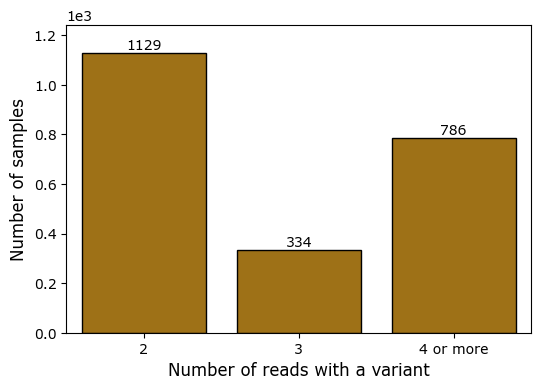

In [67]:

# plot 

color_hist = '#b57900'

# let's do this only for >= 2 reads data 
plt.figure(figsize=(6,4)) # set figure size

nums_ns = pd.DataFrame(num_table_ns.groupby('read count')['count'].sum()).reset_index()
nums_ns_list = num_table_ns.groupby('read count')['count'].sum().tolist()
sns.barplot(x = nums_ns['read count'], y = nums_ns['count'], color=color_hist, edgecolor = 'black')

# add annotation on top of each bar to indicate number of samples (not sure if this is helpful)
ax = plt.gca()
for i, v in enumerate(nums_ns_list):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.ylim(0, 1.1 * max(num_table_ns['count'])) # y axis limits
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # scientific notation

plt.xlabel('Number of reads with a variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

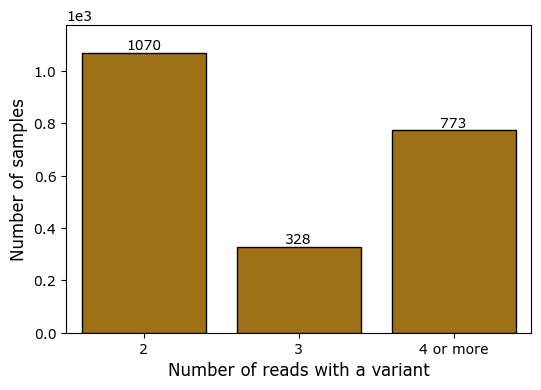

In [68]:
# do the same but for the 20 reasonably common variants (>= 10 samples)
# create a df which contains counts across different read numbers
num_table_10 = pd.DataFrame(batch_gene_vars_10['var_depth'].value_counts())
num_table_10 = num_table_10.sort_values(by = 'var_depth')

num_table_10['reads'] = num_table_10.index
num_table_10 = num_table_10.reset_index(drop=True)

conditions_10 = [
    (num_table_10['reads'] == 2),
    (num_table_10['reads'] == 3),
    (num_table_10['reads'] >= 4)
]
values_10 = ['2', '3', '4 or more']

# create new column based on conditions
num_table_10['read count'] = np.select(conditions_10, values_10, default='1')
num_table_10 = num_table_10[['reads', 'read count', 'count']]
num_table_10['read count'] = num_table_10['read count'].astype('category')

# let's do this only for >= 2 reads data 
plt.figure(figsize=(6,4)) # set figure size

nums_10 = pd.DataFrame(num_table_10.groupby('read count')['count'].sum()).reset_index()
nums_10_list = num_table_10.groupby('read count')['count'].sum().tolist()
sns.barplot(x = nums_10['read count'], y = nums_10['count'], color=color_hist, edgecolor = 'black')

# add annotation on top of each bar to indicate number of samples (not sure if this is helpful)
ax = plt.gca()
for i, v in enumerate(nums_10_list):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.ylim(0, 1.1 * max(num_table_10['count'])) # y axis limits
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # scientific notation

plt.xlabel('Number of reads with a variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

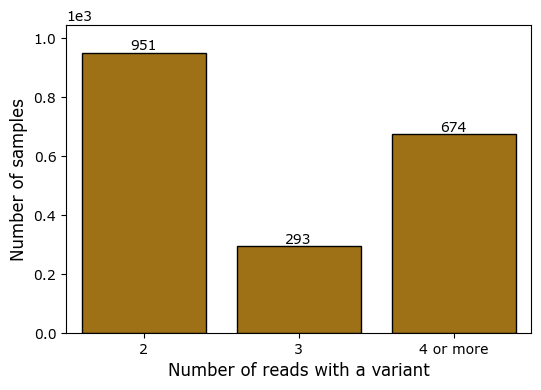

In [69]:
# now do it for samples which have been filtered (healthy ones), only including top 20 variants

num_table_10 = pd.DataFrame(batch_gene_vars_10_age['var_depth'].value_counts())
num_table_10 = num_table_10.sort_values(by = 'var_depth')

num_table_10['reads'] = num_table_10.index
num_table_10 = num_table_10.reset_index(drop=True)

conditions_10 = [
    (num_table_10['reads'] == 2),
    (num_table_10['reads'] == 3),
    (num_table_10['reads'] >= 4)
]
values_10 = ['2', '3', '4 or more']

# create new column based on conditions
num_table_10['read count'] = np.select(conditions_10, values_10, default='1')
num_table_10 = num_table_10[['reads', 'read count', 'count']]
num_table_10['read count'] = num_table_10['read count'].astype('category')

# let's do this only for >= 2 reads data 
plt.figure(figsize=(6,4)) # set figure size

nums_10 = pd.DataFrame(num_table_10.groupby('read count')['count'].sum()).reset_index()
nums_10_list = num_table_10.groupby('read count')['count'].sum().tolist()
sns.barplot(x = nums_10['read count'], y = nums_10['count'], color=color_hist, edgecolor = 'black')

# add annotation on top of each bar to indicate number of samples (not sure if this is helpful)
ax = plt.gca()
for i, v in enumerate(nums_10_list):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom')

plt.ylim(0, 1.1 * max(num_table_10['count'])) # y axis limits
plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # scientific notation

plt.xlabel('Number of reads with a variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

In [71]:

# define function to create a barplot 
def plot_barplot(df, x, y, color, xlabel, ylabel, name, title = None):
    
    plt.figure(figsize = (10,4)) # set figure size
    sns.barplot(x = df[x].astype(str), y = df[y], color = color, edgecolor = 'black')

    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize = 12)
    plt.xticks(rotation=90, fontsize = 9)
    plt.yticks(fontsize = 10)

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 2/2e_barchart_{name}.pdf', bbox_inches='tight')


In [72]:
# subset df so you only plot for variants you will be looking at
gene_vars_sorted_ns = gene_vars_sorted_ns[gene_vars_sorted_ns['gene_var'].isin(variants_to_examine)]
gene_vars_sorted_ns['gene_var2'] = gene_vars_sorted_ns['gene_var'].str.replace('_', '\n')

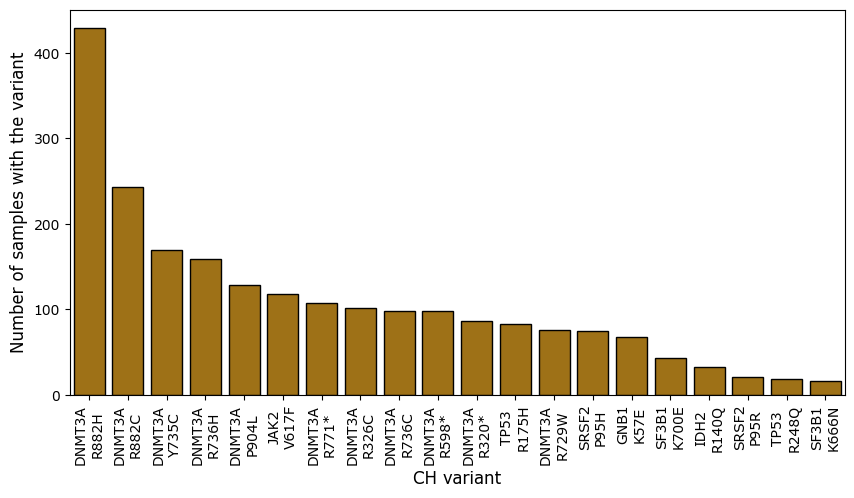

In [115]:

# note: this is for 20 variants, not filtered by healthy / not healthy / MHC etc.
# plot_barplot(gene_vars_sorted_ns, 'gene_var2', 'count', color_hist, 'CH variant', 'Number of samples with the variant', 'nr_samples_per_var_ns', 'Number of samples with a given CH variant')

In [73]:
# distribution of doubletons (as % of total)

# number of doubletons
batch_doubletons = batch_gene_vars_ns[batch_gene_vars_ns['var_depth'] == 2] 
double_gene_vars = pd.DataFrame(batch_doubletons['gene_var'].value_counts())
double_gene_vars['gene_var'] = double_gene_vars.index
double_gene_vars = double_gene_vars.reset_index(drop=True)
double_gene_vars = double_gene_vars.sort_values(by = 'count', ascending=False)

# get singletones as % total for each variant
double_gene_vars = double_gene_vars.rename(columns={'count': 'doubletons'})
vars_counts_2 = pd.merge(double_gene_vars, gene_vars_count_ns, on = 'gene_var')
vars_counts_2['percent_doubletons'] = vars_counts_2['doubletons'] / vars_counts_2['count'] * 100
vars_counts_2 = vars_counts_2.sort_values(by = 'percent_doubletons', ascending=False)

print('Number of identified samples with doubletons:', batch_doubletons.shape[0])
print('Doubletons constitute from', int(min(vars_counts_2['percent_doubletons'].tolist())), 'to', int(max(vars_counts_2['percent_doubletons'].tolist())), 'percent of the sample')


Number of identified samples with doubletons: 1129
Doubletons constitute from 14 to 100 percent of the sample


In [74]:
# choose only variants we will be looking at 
vars_counts_2 = vars_counts_2[vars_counts_2['gene_var'].isin(variants_to_examine)]
vars_counts_2['gene_var2'] = vars_counts_2['gene_var'].str.replace('_', '\n')

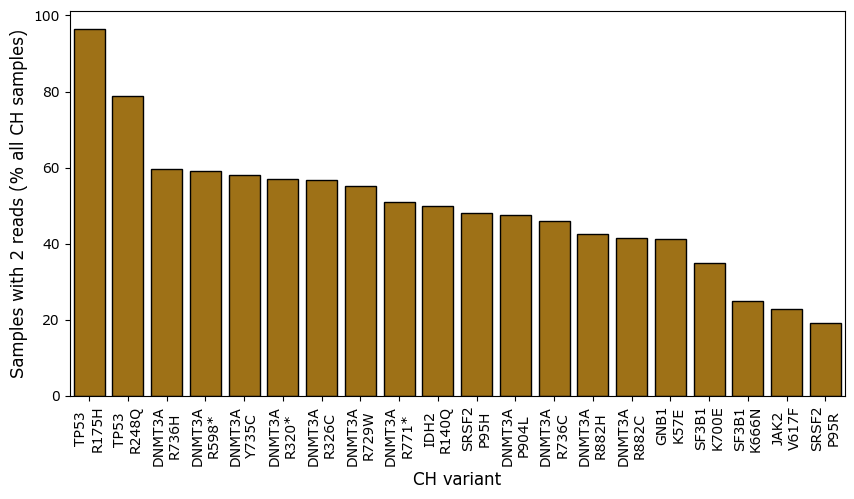

In [116]:
# For each variant, plot the % of reads constituted by singletons
# plot_barplot(vars_counts_2, 'gene_var2', 'percent_doubletons', color_hist, 'CH variant', 'Samples with 2 reads (% all CH samples)', 'percent_doubletons_per_var', 'Percentage of doubletons across CH variants')


In [76]:
# only include healthy individuals 
gene_vars_count_age = pd.DataFrame(batch_gene_vars_10_age['gene_var'].value_counts())
gene_vars_count_age['gene_var'] = gene_vars_count_age.index
gene_vars_count_age = gene_vars_count_age.reset_index(drop=True)
gene_vars_sorted_age = gene_vars_count_age.sort_values(by = 'count', ascending=False)
gene_vars_sorted_age = gene_vars_sorted_age[gene_vars_sorted_age['gene_var'].isin(variants_to_examine)]
gene_vars_sorted_age['gene_var2'] = gene_vars_sorted_age['gene_var'].str.replace('_', '\n')
# plot_barplot(gene_vars_sorted_age, 'gene_var2', 'count', color_hist, 'CH variant', 'Number of samples with the variant', 'nr_samples_per_var_healthy', 'Number of samples with a given CH variant')

# number of doubletons
batch_doubletons_age = batch_gene_vars_10_age[batch_gene_vars_10_age['var_depth'] == 2] 
double_gene_vars_age = pd.DataFrame(batch_doubletons_age['gene_var'].value_counts())
double_gene_vars_age['gene_var'] = double_gene_vars_age.index
double_gene_vars_age = double_gene_vars_age.reset_index(drop=True)
double_gene_vars_age = double_gene_vars_age.sort_values(by = 'count', ascending=False)
double_gene_vars_age = double_gene_vars_age.rename(columns={'count': 'doubletons'})
vars_counts_2_age = pd.merge(double_gene_vars_age, gene_vars_count_age, on = 'gene_var')
vars_counts_2_age['percent_doubletons'] = vars_counts_2_age['doubletons'] / vars_counts_2_age['count'] * 100
vars_counts_2_age = vars_counts_2_age.sort_values(by = 'percent_doubletons', ascending=False)
# choose only variants we will be looking at 
vars_counts_2_age = vars_counts_2_age[vars_counts_2_age['gene_var'].isin(variants_to_examine)]
vars_counts_2_age['gene_var2'] = vars_counts_2_age['gene_var'].str.replace('_', '\n')
# plot_barplot(vars_counts_2_age, 'gene_var2', 'percent_doubletons', color_hist, 'CH variant', 'Samples with 2 reads (% all CH samples)', 'percent_doubletons_per_var_healthy', 'Percentage of doubletons across CH variants')


# Add the numbers for people filtered for correct MHC genotype

In [78]:

# add MHC genotype data to CH cases

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# load the dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

# clean up the dataset (filtering according to Krishna et al., 2024 Science: remove people in whom not all alleles were genotyped with sufficient confidence)
df_clean_hla1 = df_hla1[~df_hla1.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla1 = df_clean_hla1[~df_clean_hla1.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype

print("Number of samples with imputed HLA:", df_hla1.shape[0])
print("Number of samples with confidently imputed MHC I:", df_clean_hla1.shape[0])
print("Number of samples with confidently imputed MHC II:", df_clean_hla2.shape[0])

# identify people who have correctly genotyped MHC class I and class II 
ids_hla1 = df_clean_hla1.Person_ID.tolist()
ids_hla2 = df_clean_hla2.Person_ID.tolist()
ids_correct_genotype = list(set(ids_hla1).intersection(ids_hla2))
print('Number of UKBB participants with correctly genotyped MHC class I and II:', len(ids_correct_genotype))


Number of samples with imputed HLA: 488377
Number of samples with confidently imputed MHC I: 443620
Number of samples with confidently imputed MHC II: 378317
Number of UKBB participants with correctly genotyped MHC class I and II: 346968


Number of samples with correct MHC I genotype: 1737


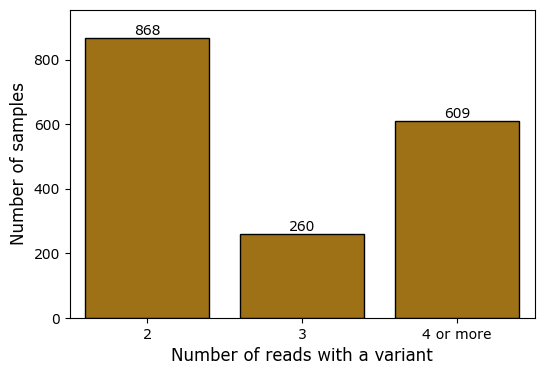

In [79]:
# plot the numbers again but now also having filtered for people for whom you have the correct genotype
# only include healthy individuals 

# add mhc genotype
batch_gene_vars_10_age_mhc = batch_gene_vars_10_age[batch_gene_vars_10_age['sample_ID'].isin(ids_hla1)]
print('Number of samples with correct MHC I genotype:', batch_gene_vars_10_age_mhc.shape[0])

num_table_10 = pd.DataFrame(batch_gene_vars_10_age_mhc['var_depth'].value_counts())
num_table_10 = num_table_10.sort_values(by = 'var_depth')
num_table_10['reads'] = num_table_10.index
num_table_10 = num_table_10.reset_index(drop=True)
conditions_10 = [
    (num_table_10['reads'] == 2),
    (num_table_10['reads'] == 3),
    (num_table_10['reads'] >= 4)
]
values_10 = ['2', '3', '4 or more']
# create new column based on conditions
num_table_10['read count'] = np.select(conditions_10, values_10, default='1')
num_table_10 = num_table_10[['reads', 'read count', 'count']]
num_table_10['read count'] = num_table_10['read count'].astype('category')
nums_10 = pd.DataFrame(num_table_10.groupby('read count')['count'].sum()).reset_index()
nums_10_list = num_table_10.groupby('read count')['count'].sum().tolist()

plt.figure(figsize=(6,4)) # set figure size
sns.barplot(x = nums_10['read count'], y = nums_10['count'], color=color_hist, edgecolor = 'black')
ax = plt.gca()
for i, v in enumerate(nums_10_list):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom')
plt.ylim(0, 1.1 * max(num_table_10['count'])) # y axis limits
# plt.gca().ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # scientific notation
plt.xlabel('Number of reads with a variant', fontsize = 12)
plt.ylabel('Number of samples', fontsize = 12)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

# counts for each variant 
gene_vars_count_age = pd.DataFrame(batch_gene_vars_10_age_mhc['gene_var'].value_counts())
gene_vars_count_age['gene_var'] = gene_vars_count_age.index
gene_vars_count_age = gene_vars_count_age.reset_index(drop=True)
gene_vars_sorted_age = gene_vars_count_age.sort_values(by = 'count', ascending=False)
gene_vars_sorted_age = gene_vars_sorted_age[gene_vars_sorted_age['gene_var'].isin(variants_to_examine)]
gene_vars_sorted_age['gene_var2'] = gene_vars_sorted_age['gene_var'].str.replace('_', '\n')
# plot_barplot(gene_vars_sorted_age, 'gene_var2', 'count', color_hist, 'CH variant', 'Number of samples with the variant', 'nr_samples_per_var_healthy_with_mhc', 'Number of samples with a given CH variant')

# number of doubletons
batch_doubletons_age = batch_gene_vars_10_age_mhc[batch_gene_vars_10_age_mhc['var_depth'] == 2] 
double_gene_vars_age = pd.DataFrame(batch_doubletons_age['gene_var'].value_counts())
double_gene_vars_age['gene_var'] = double_gene_vars_age.index
double_gene_vars_age = double_gene_vars_age.reset_index(drop=True)
double_gene_vars_age = double_gene_vars_age.sort_values(by = 'count', ascending=False)
double_gene_vars_age = double_gene_vars_age.rename(columns={'count': 'doubletons'})
vars_counts_2_age = pd.merge(double_gene_vars_age, gene_vars_count_age, on = 'gene_var')
vars_counts_2_age['percent_doubletons'] = vars_counts_2_age['doubletons'] / vars_counts_2_age['count'] * 100
vars_counts_2_age = vars_counts_2_age.sort_values(by = 'percent_doubletons', ascending=False)
# choose only variants we will be looking at 
vars_counts_2_age = vars_counts_2_age[vars_counts_2_age['gene_var'].isin(variants_to_examine)]
vars_counts_2_age['gene_var2'] = vars_counts_2_age['gene_var'].str.replace('_', '\n')
# plot_barplot(vars_counts_2_age, 'gene_var2', 'percent_doubletons', color_hist, 'CH variant', 'Samples with 2 reads (% CH samples)', 'percent_doubletons_per_var_healthy_with_mhc', 'Percentage of doubletons across CH variants')


In [80]:
# prep df for plotting 
vars_counts_2_age['more'] = vars_counts_2_age['count'] - vars_counts_2_age['doubletons']
vars_counts_2_age['percent_doubletons'] = vars_counts_2_age['percent_doubletons'].round(0)
vars_counts_2_age_sort = vars_counts_2_age.sort_values(by = 'count', ascending = False)

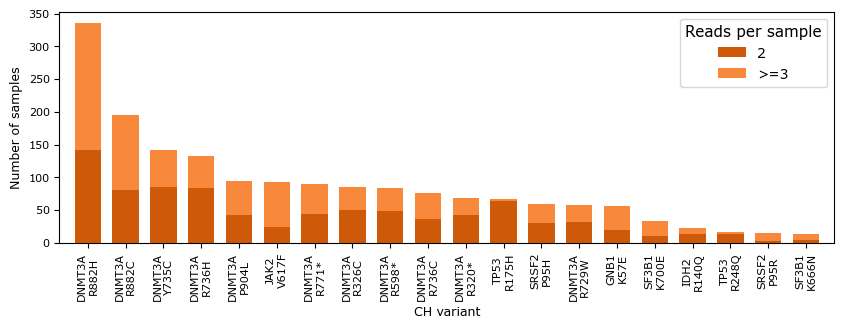

: 

In [81]:
# okay how about we plot doubletons on a stacked barchart to only have one figure bc this is a horror to fit in otherwise
colors = ['#CD5909', '#F8883B']

plt.figure(figsize=(10, 3))

bar_width = 1.4
bar_positions = np.arange(len(vars_counts_2_age_sort))  # Use numpy's arange for evenly spaced x-coordinates
offset = 0.2
bars_double= plt.bar(2*bar_positions, vars_counts_2_age_sort['doubletons'], color=colors[0], width=bar_width, label='2') # het at the bottom
bars_more = plt.bar(2*bar_positions, vars_counts_2_age_sort['more'], color=colors[1], width=bar_width, label='>=3', bottom=vars_counts_2_age_sort['doubletons']) # stack het on hom

plt.xticks(2*bar_positions, vars_counts_2_age_sort['gene_var2'], fontsize = 9)
plt.xlabel('CH variant', fontsize = 9)
plt.ylabel('Number of samples', fontsize = 9)
plt.xticks(rotation = 90, fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlim(-1.5, 39.5)

# for bar1, bar2, percent_1 in zip(bars_double, bars_more, vars_counts_2_age_sort['percent_doubletons']):
#     plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + bar2.get_height(), f'{round(percent_1)}%', 
#              ha='center', va='bottom', fontsize=9, color='black')

plt.legend(loc = 'upper right', title = 'Reads per sample', fontsize = 10, title_fontsize = 11)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 2/2e_barchart_nr_samples_per_var_with_2reads_3reads.pdf', bbox_inches='tight')
